# Desafio Kaggle I

## Grupo: RedesNeurodivergentes

### Integrantes:

- Etienne Rojas - 201904033-2





- Renato Burgos - 201973021-5

- Diego Varela - 201973065-7

Instalar e instalar paquetes

In [36]:
!pip install -q keras-core

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import requests
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.decomposition import PCA
import seaborn as sns
import keras_core as keras

from sklearn.model_selection import train_test_split
os.environ["KERAS_BACKEND"] = "tensorflow" # 'torch', 'tensorflow', 'jax'
SEED = 42
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
keras.utils.set_random_seed(SEED)

### Helper F(x)

In [38]:
def plot_losses(history, loss):
  # Función para graficar la función de pérdida del modelo
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Error Graph')
  plt.ylabel(loss.name)
  plt.xlabel('epoch')
  plt.legend(['train', 'val'], loc='upper left')
  plt.show()

### Cargar los datos

In [39]:
df_original = pd.read_csv('train_data.csv')

### EDA

### Mapa de calor de las correlaciones

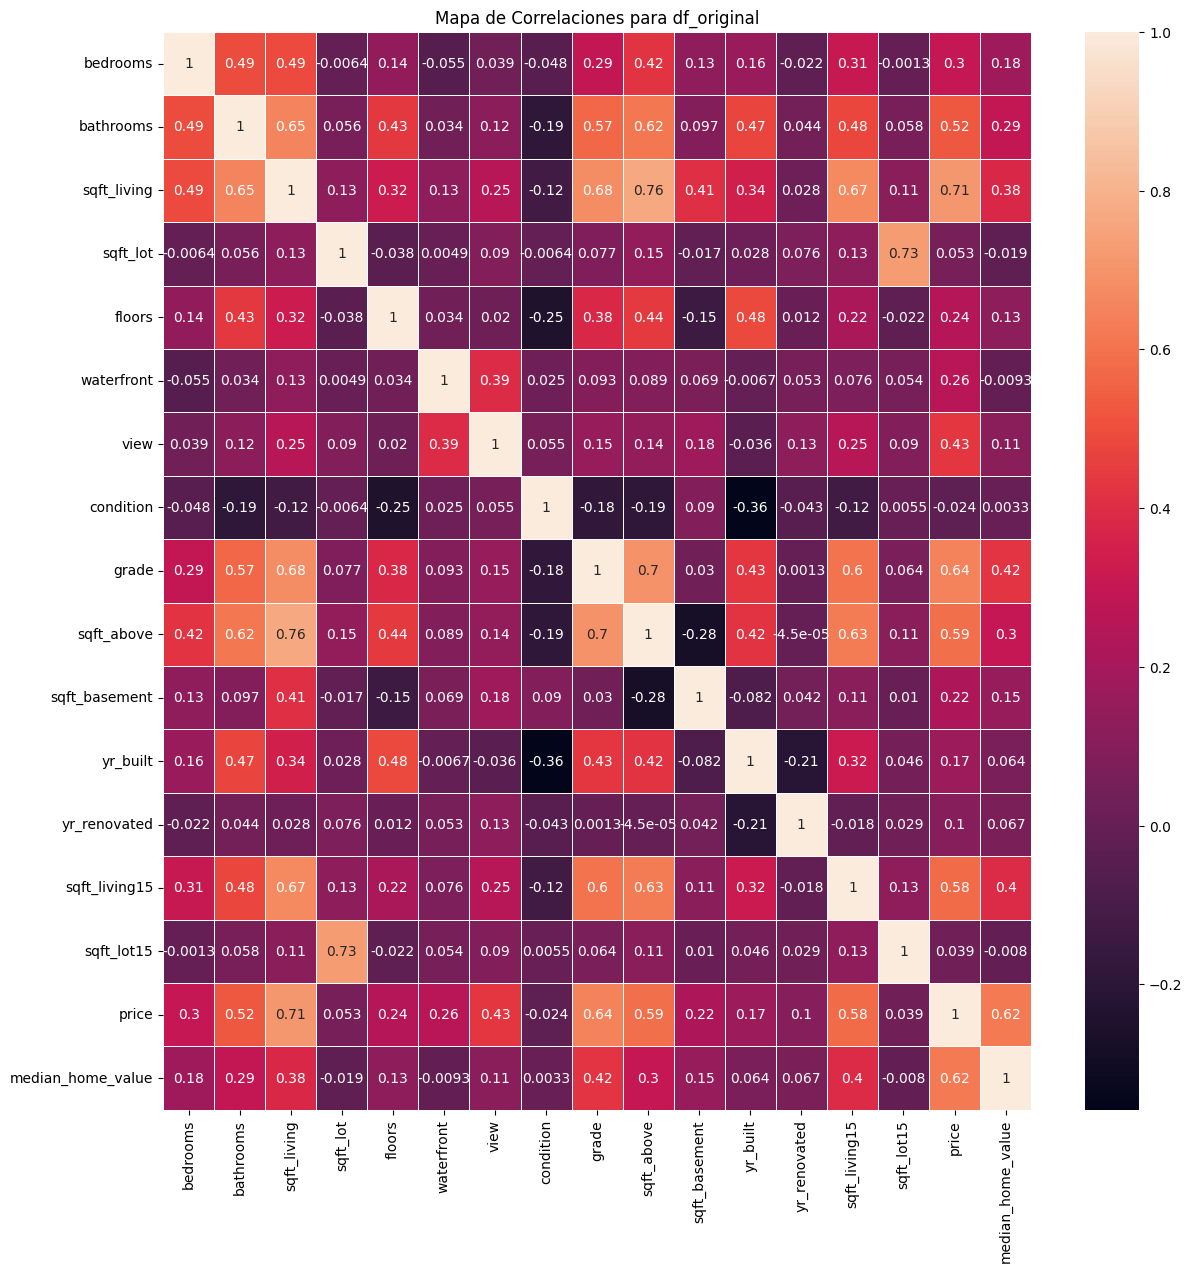

In [59]:
correlation_matrix_original = df_original.corr()
# Crear el primer gráfico para df_original
plt.figure(figsize=(14, 14))
sns.heatmap(correlation_matrix_original, annot=True, cmap='rocket', linewidths=0.5)
plt.title('Mapa de Correlaciones para df_original')
plt.show()


Hay correlaciones altas entre las siguientes variables, antes de normalizar:

- sqft_above - sqft_living (0.89)

- sqft_lot15 - sqft_lot (0.81)

- sqft_above - grade (0.81)

- grade - sqft_living(0.81)

A pesar de que normalizar atenua un poco las correlaciones, igualmente vamos a hacer una reducción de dimensiones utilizando PCA

In [41]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1276 entries, 0 to 1275
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             1276 non-null   int64  
 1   date           1276 non-null   object 
 2   zipcode        1276 non-null   int64  
 3   lat            1276 non-null   float64
 4   long           1276 non-null   float64
 5   bedrooms       1074 non-null   float64
 6   bathrooms      1079 non-null   float64
 7   sqft_living    1082 non-null   float64
 8   sqft_lot       1087 non-null   float64
 9   floors         1084 non-null   float64
 10  waterfront     1076 non-null   float64
 11  view           1082 non-null   float64
 12  condition      1095 non-null   float64
 13  grade          1086 non-null   float64
 14  sqft_above     1089 non-null   float64
 15  sqft_basement  1093 non-null   float64
 16  yr_built       1113 non-null   float64
 17  yr_renovated   1075 non-null   float64
 18  sqft_liv

Notamos que hay muchos campos con valores null.


### Rellenar los null y nan

In [42]:
# Funciones para rellenar null y nans
def impute_nan_values(df):
    # Imputar con la mediana
    for col in ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'yr_built']:
        df[col].fillna(df[col].median(), inplace=True)

    # Imputar con la moda
    for col in ['waterfront', 'view', 'condition', 'grade']:
        df[col].fillna(df[col].mode()[0], inplace=True)

    # Imputar yr_renovated con 0 (asumiendo que NaN significa que no ha sido renovado)
    df['yr_renovated'].fillna(0, inplace=True)

    # Imputar sqft_basement basado en sqft_living y sqft_above
    df['sqft_basement'] = df['sqft_living'] - df['sqft_above']
    return df


### Feature Engineering

- Analizando los zipcode, nos damos cuenta que todos pertenecen al King County de Washington, asi que ocupamos esta página: https://www.unitedstateszipcodes.org/, para obtener el precio medio de una casa dentro del area relacionada a un zipcode en el año 2020

In [43]:
# Zipcode : Precio mediano de tales sectores en 2020
zipcode_dict = {
    98003: 221600,
    98117: 463500,
    98106: 281700,
    98144: 391600,
    98038: 391600,
    98002: 167100,
    98058: 302200,
    98045: 368300,
    98092: 287600,
    98014: 410900,
    98146: 308400,
    98107: 447700,
    98028: 386200,
    98136: 445700,
    98053: 544500,
    98005: 568700,
    98056: 342600,
    98148: 255900,
    98008: 457200,
    98075: 614100,
    98074: 556000,
    98115: 492700,
    98055: 266100,
    98022: 300800,
    98019: 376600,
    98178: 283100,
    98023: 265100,
    98027: 478800,
    98116: 467900,
    98001: 268800,
    98032: 234700,
    98033: 528300,
    98077: 570700,
    98070: 413400,
    98042: 297100,
    98188: 226800,
    98004: 723300,
    98126: 358100,
    98118: 350700,
    98072: 466100,
    98030: 251700,
    98059: 363500,
    98040: 864600,
    98007: 379600,
    98155: 340900,
    98103: 478200,
    98166: 386900,
    98199: 606200,
    98029: 446900,
    98177: 478600,
    98034: 364900,
    98052: 465200,
    98133: 326400,
    98168: 240000,
    98198: 258500,
    98011: 221600,
    98122: 407600,
    98108: 326500,
    98031: 271500,
    98006: 574000,
    98125: 372000,
    98010: 319300,
    98105: 613900,
    98024: 490600,
    98109: 451400,
    98112: 754200,
    98224: 182200,
    98039: 1000001,
    98354: 229600,
    98051: 378400,
    98047: 220200,
    98050: 760000,
    98057: 256900,
    98101: 420800,
    98102: 406000,
    98104: 392000,
    98119: 608300,
    98121: 417100,
    98134: 234400,
    98154: 392000,
    98158: 277400,
    98164: 392000,
    98174: 392000,
    98195: 684050,
    98288: 172200,
    98065: 418900,
    98068: 366900
}

In [44]:
df_original = pd.read_csv('train_data.csv')


    id - ID de la propiedad
    date - Fecha
    zipcode - Código Postal
    lat - Latitud
    long - Longitud
    bedrooms - Cantidad de Piezas
    bathrooms - Cantidad de Baños
    sqft_living - área Total de la propiedad
    sqft_lot - Área del Terreno de la propiedad
    floors - Cantidad de Pisos
    waterfront - Vista a alguna fuente de agua (lago, rio, etc.) (0 no tiene, 1 si tiene)
    view - calidad de la vista (0 peor, 4 la mejor)
    condition - Condición de la propiedad (1 la peor, 5 la mejor)
    grade - Construcción, diseño y calidad de la propiedad (1 poca calidad, 13 la mejor calidad y construcción)
    sqft_above - Área del interior de la casa sobre el nivel del suelo
    sqft_basement - Área del Sótano bajo nivel del suelo
    yr_built - Año de construcción
    yr_renovated - Año de renovación
    sqft_living15 - Área promedio de las 15 propiedades vecinas
    sqft_lot15 - Área promedio del terreno de las 15 propiedades vecinas


A continuación creamos una nueva columna con los datos obtenidos a partir del zipcode, y además droppeamos los valores que consideramos no aportan a la red.

In [45]:
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df_original = df_original.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

Le damos valor a los nan de las celdas

In [46]:
df = impute_nan_values(df_original)
df.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,sqft_living15,sqft_lot15,price,median_home_value
0,3.0,2.25,1590.0,7748.0,2.0,0.0,0.0,4.0,7.0,1590.0,0.0,1991.0,0.0,1590.0,7606.0,263000.0,221600
1,3.0,2.25,2040.0,4005.0,1.5,0.0,0.0,4.0,8.0,1740.0,300.0,1930.0,0.0,1380.0,4005.0,620000.0,463500
2,2.0,1.00,640.0,7768.0,1.0,0.0,0.0,3.0,6.0,640.0,0.0,1942.0,0.0,1880.0,7424.0,165000.0,281700
3,2.0,1.50,1240.0,8145.0,1.5,0.0,0.0,3.0,8.0,1080.0,160.0,1971.0,0.0,1530.0,1209.0,403000.0,391600
4,3.0,2.25,1990.0,8145.0,2.0,0.0,0.0,3.0,7.0,1990.0,0.0,2010.0,0.0,2580.0,3800.0,318200.0,391600


Se probaron varias cosas y una vez que llegamos a un resultado que consideramos decente lo subimos a kaggle, más adelante iteraremos sobre el modelo con mejor resultado esperando mejorarlo.

# Red 1

In [47]:
X_train = df.drop(['price'], axis = 1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

# Capas de preprocesamiento
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

# A continuación, se añaden las capas de la red
x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='linear')(x)

model = keras.Model(inputs=inputs, outputs=output)

Epoch 1/200
8/8 [==============================] - 3s 37ms/step - loss: 430716551168.0000 - mean_squared_error: 430716551168.0000 - mean_absolute_error: 550257.3125 - val_loss: 523221893120.0000 - val_mean_squared_error: 523221893120.0000 - val_mean_absolute_error: 604276.1250
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 430706982912.0000 - mean_squared_error: 430706982912.0000 - mean_absolute_error: 550249.7500 - val_loss: 523205312512.0000 - val_mean_squared_error: 523205312512.0000 - val_mean_absolute_error: 604264.1875
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 430685814784.0000 - mean_squared_error: 430685814784.0000 - mean_absolute_error: 550232.7500 - val_loss: 523169955840.0000 - val_mean_squared_error: 523169955840.0000 - val_mean_absolute_error: 604239.1250
Epoch 4/200
8/8 [==============================] - 0s 13ms/step - loss: 430641610752.0000 - mean_squared_error: 430641610752.0000 - mean_absolute_error: 550197.1250 - 

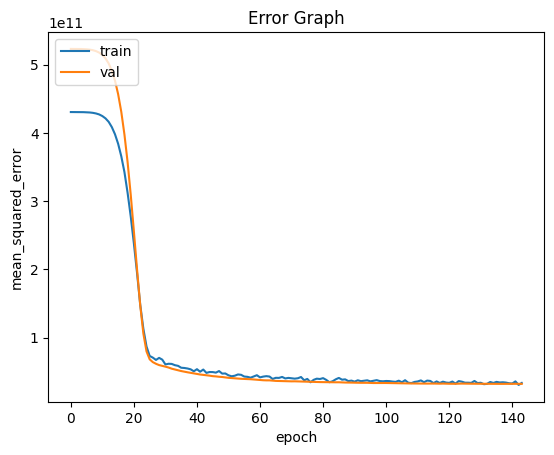

In [48]:
# Hiperparámetros
epochs = 200
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)

In [49]:

df_test = pd.read_csv('test_data.csv')
df_test['median_home_value'] = df_test['zipcode'].map(zipcode_dict)
df_test = df_test.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)
for col in ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'yr_built']:
    df_test[col].fillna(df_original[col].median(), inplace=True)

# Imputar con la moda
for col in ['waterfront', 'view', 'condition', 'grade']:
    df_test[col].fillna(df_original[col].mode()[0], inplace=True)

# Imputar yr_renovated con 0 (asumiendo que NaN significa que no ha sido renovado)
df_test['yr_renovated'].fillna(0, inplace=True)

# Imputar sqft_basement basado en sqft_living y sqft_above
df_test['sqft_basement'] = df_original['sqft_living'] - df_original['sqft_above']
x_test = df_test.copy()
score = model.predict(x_test)
df_test.info()

10/10 [==============================] - 0s 3ms/step
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 320 entries, 0 to 319
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bedrooms           320 non-null    float64
 1   bathrooms          320 non-null    float64
 2   sqft_living        320 non-null    float64
 3   sqft_lot           320 non-null    float64
 4   floors             320 non-null    float64
 5   waterfront         320 non-null    float64
 6   view               320 non-null    float64
 7   condition          320 non-null    float64
 8   grade              320 non-null    float64
 9   sqft_above         320 non-null    float64
 10  sqft_basement      320 non-null    float64
 11  yr_built           320 non-null    float64
 12  yr_renovated       320 non-null    float64
 13  sqft_living15      320 non-null    float64
 14  sqft_lot15         320 non-null    float64
 15  median_home_value  32

In [50]:
df_test = pd.read_csv('test_data.csv')
df_test['price'] = score
df_test = df_test[['ID','price']]

In [51]:
df_test.to_csv('nombre_del_archivo.csv', index=False)

# Red 2
Cambiamos la cantidad de epochs, y además cambiamos la funcion de activación de la ultima capa, de linear a relu, por si llegabamos a una mejora.

Epoch 1/500
16/16 [==============================] - 3s 19ms/step - loss: 430716649472.0000 - mean_squared_error: 430716649472.0000 - mean_absolute_error: 550257.1875 - val_loss: 523225858048.0000 - val_mean_squared_error: 523225858048.0000 - val_mean_absolute_error: 604278.6250
Epoch 2/500
16/16 [==============================] - 0s 8ms/step - loss: 430715109376.0000 - mean_squared_error: 430715109376.0000 - mean_absolute_error: 550256.0625 - val_loss: 523223760896.0000 - val_mean_squared_error: 523223760896.0000 - val_mean_absolute_error: 604277.3125
Epoch 3/500
16/16 [==============================] - 0s 8ms/step - loss: 430713077760.0000 - mean_squared_error: 430713077760.0000 - mean_absolute_error: 550254.4375 - val_loss: 523221270528.0000 - val_mean_squared_error: 523221270528.0000 - val_mean_absolute_error: 604275.6250
Epoch 4/500
16/16 [==============================] - 0s 8ms/step - loss: 430710521856.0000 - mean_squared_error: 430710521856.0000 - mean_absolute_error: 550252.6

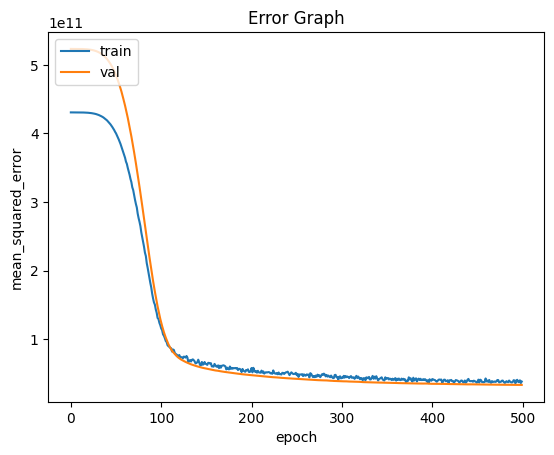

In [52]:
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df = impute_nan_values(df_original)
df = df.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

X_train = df.drop(['price'], axis = 1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=output)
epochs = 500
batch_size = 64
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)

# Red 3
Cambiamos el learning rate.

Epoch 1/500
8/8 [==============================] - 2s 33ms/step - loss: 430715240448.0000 - mean_squared_error: 430715240448.0000 - mean_absolute_error: 550256.5625 - val_loss: 523224416256.0000 - val_mean_squared_error: 523224416256.0000 - val_mean_absolute_error: 604278.1875
Epoch 2/500
8/8 [==============================] - 0s 11ms/step - loss: 430714159104.0000 - mean_squared_error: 430714159104.0000 - mean_absolute_error: 550255.6875 - val_loss: 523222908928.0000 - val_mean_squared_error: 523222908928.0000 - val_mean_absolute_error: 604277.2500
Epoch 3/500
8/8 [==============================] - 0s 9ms/step - loss: 430712913920.0000 - mean_squared_error: 430712913920.0000 - mean_absolute_error: 550254.7500 - val_loss: 523221270528.0000 - val_mean_squared_error: 523221270528.0000 - val_mean_absolute_error: 604276.1875
Epoch 4/500
8/8 [==============================] - 0s 11ms/step - loss: 430711406592.0000 - mean_squared_error: 430711406592.0000 - mean_absolute_error: 550253.6875 - 

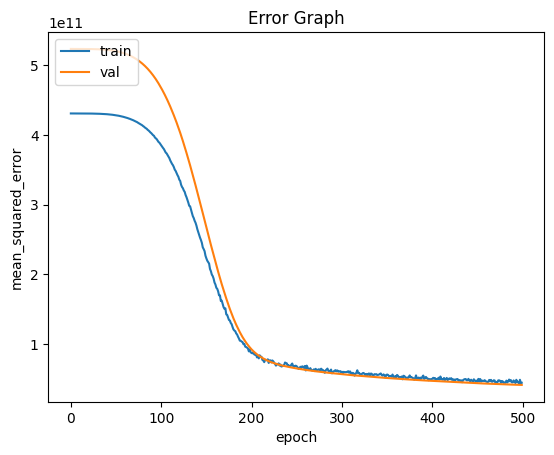

In [53]:
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df = impute_nan_values(df_original)
df = df.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

X_train = df.drop(['price'], axis = 1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='relu')(x)

model = keras.Model(inputs=inputs, outputs=output)
epochs = 500
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-4)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)


# Red 4
Añadimos mas capas.

Epoch 1/200
8/8 [==============================] - 3s 37ms/step - loss: 430707703808.0000 - mean_squared_error: 430707703808.0000 - mean_absolute_error: 550250.6875 - val_loss: 523191549952.0000 - val_mean_squared_error: 523191549952.0000 - val_mean_absolute_error: 604256.1250
Epoch 2/200
8/8 [==============================] - 0s 9ms/step - loss: 430647246848.0000 - mean_squared_error: 430647246848.0000 - mean_absolute_error: 550204.1875 - val_loss: 523052974080.0000 - val_mean_squared_error: 523052974080.0000 - val_mean_absolute_error: 604163.0625
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 430425112576.0000 - mean_squared_error: 430425112576.0000 - mean_absolute_error: 550035.8125 - val_loss: 522597236736.0000 - val_mean_squared_error: 522597236736.0000 - val_mean_absolute_error: 603858.7500
Epoch 4/200
8/8 [==============================] - 0s 10ms/step - loss: 429746946048.0000 - mean_squared_error: 429746946048.0000 - mean_absolute_error: 549522.8750 - 

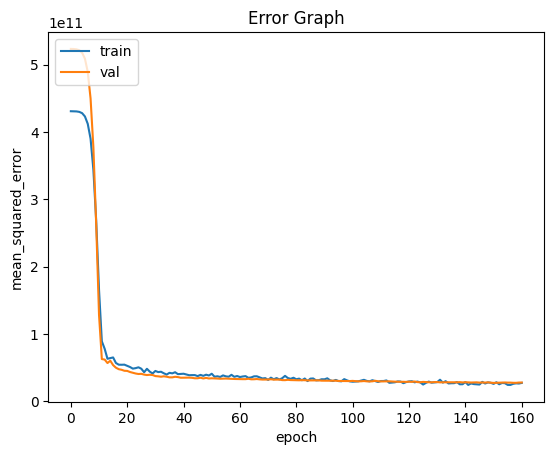

In [54]:
# Hiperpametros
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df = impute_nan_values(df_original)
df = df.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

X_train = df.drop(['price'], axis = 1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

# Añadimos otra capa a la red.
x = layers.Dense(512, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inputs, outputs=output)
epochs = 200
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)

# Red 5
Cambiamos la arquitectura

Epoch 1/200
8/8 [==============================] - 3s 111ms/step - loss: 430711373824.0000 - mean_squared_error: 430711373824.0000 - mean_absolute_error: 550253.3125 - val_loss: 523200200704.0000 - val_mean_squared_error: 523200200704.0000 - val_mean_absolute_error: 604261.1250
Epoch 2/200
8/8 [==============================] - 0s 12ms/step - loss: 430657437696.0000 - mean_squared_error: 430657437696.0000 - mean_absolute_error: 550210.0000 - val_loss: 523066769408.0000 - val_mean_squared_error: 523066769408.0000 - val_mean_absolute_error: 604168.8750
Epoch 3/200
8/8 [==============================] - 0s 10ms/step - loss: 430431010816.0000 - mean_squared_error: 430431010816.0000 - mean_absolute_error: 550036.2500 - val_loss: 522595532800.0000 - val_mean_squared_error: 522595532800.0000 - val_mean_absolute_error: 603846.1250
Epoch 4/200
8/8 [==============================] - 0s 12ms/step - loss: 429716701184.0000 - mean_squared_error: 429716701184.0000 - mean_absolute_error: 549484.0000 

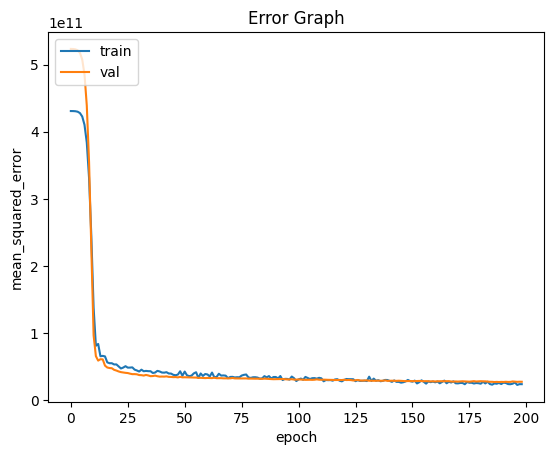

In [55]:
# Hiperparámetros
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df = impute_nan_values(df_original)
df = df.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

X_train = df.drop(['price'], axis = 1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

# Añadir capas de preprocesamiento
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

# Ajustamos el número de neuronas

x = layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inputs, outputs=output)
epochs = 200
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)

In [56]:
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df_original = impute_nan_values(df_original)
df_original = df_original.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)

df_test = pd.read_csv('test_data.csv')
df_test['median_home_value'] = df_test['zipcode'].map(zipcode_dict)
df_test = df_test.drop(['ID','date', 'zipcode', 'lat', 'long'], axis = 1)
for col in ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'yr_built']:
    df_test[col].fillna(df_original[col].median(), inplace=True)


for col in ['waterfront', 'view', 'condition', 'grade']:
    df_test[col].fillna(df_original[col].mode()[0], inplace=True)


df_test['yr_renovated'].fillna(0, inplace=True)


df_test['sqft_basement'] = df_original['sqft_living'] - df_original['sqft_above']
x_test = df_test.copy()
score = model.predict(x_test)

df_test = pd.read_csv('test_data.csv')
df_test['price'] = score
df_test = df_test[['ID','price']]

df_test.to_csv('candidato.csv', index=False)


10/10 [==============================] - 0s 2ms/step


# Red 6: PCA

Epoch 1/200
8/8 [==============================] - 3s 54ms/step - loss: 430687780864.0000 - mean_squared_error: 430687780864.0000 - mean_absolute_error: 550235.1250 - val_loss: 523123556352.0000 - val_mean_squared_error: 523123556352.0000 - val_mean_absolute_error: 604208.8125
Epoch 2/200
8/8 [==============================] - 0s 15ms/step - loss: 430512701440.0000 - mean_squared_error: 430512701440.0000 - mean_absolute_error: 550098.1875 - val_loss: 522733944832.0000 - val_mean_squared_error: 522733944832.0000 - val_mean_absolute_error: 603943.2500
Epoch 3/200
8/8 [==============================] - 0s 15ms/step - loss: 429890961408.0000 - mean_squared_error: 429890961408.0000 - mean_absolute_error: 549631.7500 - val_loss: 521505603584.0000 - val_mean_squared_error: 521505603584.0000 - val_mean_absolute_error: 603110.5000
Epoch 4/200
8/8 [==============================] - 0s 18ms/step - loss: 428177915904.0000 - mean_squared_error: 428177915904.0000 - mean_absolute_error: 548311.0000 -

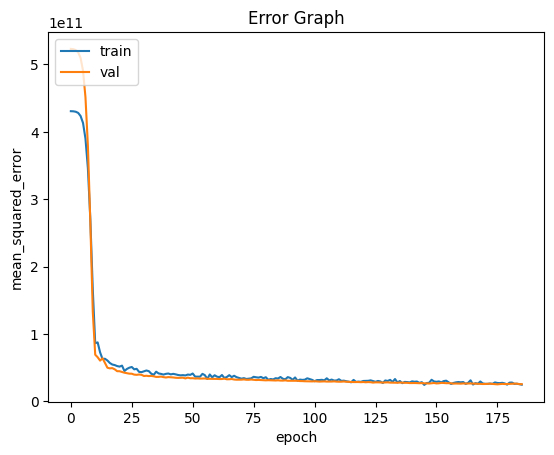

In [57]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

df_original = pd.read_csv('train_data.csv')

df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)

df = impute_nan_values(df_original)

df = df.drop(['ID', 'date', 'zipcode', 'lat', 'long'], axis=1)

# Seleccionar las variables para el PCA
variables_pca = ['sqft_above', 'sqft_living', 'grade']
X_pca = df[variables_pca]

# Estandarizar las variables para PCA
scaler = StandardScaler()
X_pca_std = scaler.fit_transform(X_pca)

# Aplicar PCA con una sola componente
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_pca_std)

# Agregar la primera componente de PCA al DataFrame
df['pca_component'] = pca_result

# Eliminar las variables originales del DataFrame
df = df.drop(variables_pca, axis=1)

# Definir las variables de entrenamiento
X_train = df.drop(['price'], axis=1)
y_train = df['price']

inputs = keras.layers.Input(shape=(X_train.shape[1],))

# Añadir capas de preprocesamiento
normalizer = layers.experimental.preprocessing.Normalization(axis=-1)
normalizer.adapt(X_train)
x = normalizer(inputs)

# Ajustamos el número de neuronas

x = layers.Dense(1024, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(256, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(128, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(64, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(32, activation='relu', kernel_initializer="he_normal")(x)
x = layers.Dropout(0.1)(x)
output = layers.Dense(1, activation='relu')(x)
model = keras.Model(inputs=inputs, outputs=output)
epochs = 200
batch_size = 128
val_split = 0.2
my_callbacks = [
    keras.callbacks.EarlyStopping(
      monitor="val_loss",
      min_delta=0,
      patience=10,
      restore_best_weights=True
    )
]

# Arquitectura

loss = keras.losses.MeanSquaredError()
opt = keras.optimizers.AdamW(learning_rate=1e-3)
model.compile(optimizer=opt,
              loss=loss,
              metrics=["mean_squared_error", "mean_absolute_error"])

# Entrenamiento del modelo
history = model.fit(
    X_train,
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_split=val_split,
    callbacks=my_callbacks,
    shuffle = True,
    verbose=1)
plot_losses(history, loss)

In [58]:
# Leer el conjunto de entrenamiento y aplicar las mismas transformaciones
df_original = pd.read_csv('train_data.csv')
df_original['median_home_value'] = df_original['zipcode'].map(zipcode_dict)
df_original = impute_nan_values(df_original)
df_original = df_original.drop(['ID','date', 'zipcode', 'lat', 'long'], axis=1)

# Seleccionar las variables para el PCA en el conjunto de entrenamiento
variables_pca = ['sqft_above', 'sqft_living', 'grade']
X_pca = df_original[variables_pca]

# Estandarizar las variables para PCA
scaler = StandardScaler()
X_pca_std = scaler.fit_transform(X_pca)

# Aplicar PCA con una sola componente en el conjunto de entrenamiento
pca = PCA(n_components=1)
pca_result = pca.fit_transform(X_pca_std)

# Crear un DataFrame para el conjunto de prueba
df_test = pd.read_csv('test_data.csv')
df_test['median_home_value'] = df_test['zipcode'].map(zipcode_dict)
df_test = df_test.drop(['ID','date', 'zipcode', 'lat', 'long'], axis=1)

# Imputar valores faltantes en el conjunto de prueba utilizando las estadísticas del conjunto de entrenamiento
for col in ['bedrooms', 'bathrooms', 'floors', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_living15', 'sqft_lot15', 'yr_built']:
    df_test[col].fillna(df_original[col].median(), inplace=True)

for col in ['waterfront', 'view', 'condition', 'grade']:
    df_test[col].fillna(df_original[col].mode()[0], inplace=True)

df_test['yr_renovated'].fillna(0, inplace=True)

# Aplicar el PCA al conjunto de prueba utilizando la misma transformación que en el conjunto de entrenamiento
X_pca_test = df_test[variables_pca]
X_pca_test_std = scaler.transform(X_pca_test)
pca_result_test = pca.transform(X_pca_test_std)

# Agregar la primera componente de PCA al DataFrame del conjunto de prueba
df_test['pca_component'] = pca_result_test
df_test['sqft_basement'] = df_original['sqft_living'] - df_original['sqft_above']

df_test = df_test.drop(variables_pca, axis=1)

x_test = df_test.copy()
score = model.predict(x_test)

df_results = pd.read_csv('test_data.csv')
df_results['price'] = score
df_results = df_results[['ID', 'price']]
df_results.to_csv('candidato.csv', index=False)

10/10 [==============================] - 0s 2ms/step
